## machine_learning: Telco

En el presente notebook vamos a aprender nuestros modelos de predicción si un cliente Abandona o no la empresa Telco NN.

Alumnos: 
 * Abritta Carolina
 * Sittner Simon

In [1]:
#Importo las librerías necesarias para realizar el EDA.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer

#Métricas
from sklearn.metrics import accuracy_score,roc_curve, auc,confusion_matrix

# Modelos
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

#ML
import sklearn
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder,MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, GridSearchCV

In [2]:
palette = sns.color_palette("husl", 2)
palette2 = sns.color_palette("husl", 3)
cmap = sns.color_palette("husl")
sns.color_palette("husl")

[(0.9677975592919913, 0.44127456009157356, 0.5358103155058701),
 (0.7350228985632719, 0.5952719904750953, 0.1944419133847522),
 (0.3126890019504329, 0.6928754610296064, 0.1923704830330379),
 (0.21044753832183283, 0.6773105080456748, 0.6433941168468681),
 (0.23299120924703914, 0.639586552066035, 0.9260706093977744),
 (0.9082572436765556, 0.40195790729656516, 0.9576909250290225)]

In [3]:
#Importamos el dataframe le colocamos la columna de numeración como índice y verificamos las primeras filas

telco = pd.read_csv('telco_churn_clusterai.csv',index_col=0)
telco_df=pd.DataFrame(telco)

### Preprocesamiento de los Datos

In [4]:
telco_df['TotalCharges'] = pd.to_numeric(telco_df['TotalCharges'], errors='coerce')
telco_df = telco_df[telco_df['TotalCharges'].notna()]
telco_df['PaymentMethod'] = telco_df['PaymentMethod'].str.replace(' (automatic)', '', regex=False)
df_sn=telco_df.dropna()
telco_df['SeniorCitizen'].fillna(telco_df['SeniorCitizen'].mode()[0], inplace=True)
telco_df['Dependents'].fillna(telco_df['Dependents'].mode()[0], inplace=True)
telco_df.loc[telco_df['TotalCharges'] <= 1500] = (telco_df.loc[telco_df['TotalCharges'] <= 1500].fillna(telco_df.loc[telco_df['TotalCharges'] <= 1500].Contract.mode()))
tot_mnew=telco_df.loc[telco_df['TotalCharges'] <= 1500]
tot_3000 = telco_df.loc[(telco_df['TotalCharges'] > 3000)]
telco_df.loc[telco_df['TotalCharges'] >= 3000] = (telco_df.loc[telco_df['TotalCharges'] >= 3000].fillna(telco_df.loc[telco_df['TotalCharges'] >= 3000].Contract.mode()))
telco_df.Contract = telco_df.Contract.fillna(telco_df.Contract.mode().iloc[0])
telco_df['PhoneService'] = telco_df.apply(lambda row: 'No' if pd.isnull(row['PhoneService']) and row['MultipleLines'] == 'No phone service' else ("Yes" if pd.isnull(row['PhoneService']) and row['MultipleLines'] == "Yes" else row['PhoneService']), axis=1)
telco_df['MultipleLines'] = telco_df.apply(lambda row: 'No' if pd.isnull(row['MultipleLines']) and row['PhoneService'] == 'No'  else row['MultipleLines'], axis=1)
telco_df['InternetService'] = telco_df.apply(lambda row: 'No' if pd.isnull(row['InternetService']) and row['OnlineSecurity'] == 'No internet service' else row['InternetService'], axis=1)
telco_df['InternetService'] = telco_df.apply(lambda row: 'No' if pd.isnull(row['InternetService']) and row['OnlineBackup'] == 'No internet service' else row['InternetService'], axis=1)
telco_df['InternetService'] = telco_df.apply(lambda row: 'No' if pd.isnull(row['InternetService']) and row['DeviceProtection'] == 'No internet service' else row['InternetService'], axis=1)
telco_df['InternetService'] = telco_df.apply(lambda row: 'No' if pd.isnull(row['InternetService']) and row['TechSupport'] == 'No internet service' else row['InternetService'], axis=1)
telco_df['InternetService'] = telco_df.apply(lambda row: 'No' if pd.isnull(row['InternetService']) and row['StreamingTV'] == 'No internet service' else row['InternetService'], axis=1)
telco_df['InternetService'] = telco_df.apply(lambda row: 'No' if pd.isnull(row['InternetService']) and row['StreamingMovies'] == 'No internet service' else row['InternetService'], axis=1)
telco_df['MonthlyCharges']=telco_df['MonthlyCharges'].fillna(telco_df['TotalCharges']/telco_df['tenure']) 
telco_df['tenure']=telco_df['tenure'].fillna(telco_df['TotalCharges']/telco_df['MonthlyCharges'])

In [5]:
columnas_a_llenar = ['Partner','PhoneService', 'PaperlessBilling','PaymentMethod','InternetService','PhoneService', 'OnlineSecurity','OnlineBackup']
for columna in columnas_a_llenar:
    if telco_df[columna].isnull().any():
        distribucion_columna = telco_df[columna].value_counts(normalize=True)
        nulos_columna = telco_df[columna].isnull().sum()
        telco_df.loc[telco_df[columna].isnull(), columna] = np.random.choice(distribucion_columna.index, p=distribucion_columna.values, size=nulos_columna)
        
telco_df['MultipleLines'] = telco_df.apply(lambda row: 'No' if pd.isnull(row['MultipleLines']) and row['PhoneService'] == 'No'  else row['MultipleLines'], axis=1)
distribucion_MultipleLines = telco_df['MultipleLines'].value_counts(normalize=True)
nulos_MultipleLines = telco_df['MultipleLines'].isnull().sum()
telco_df.loc[telco_df['MultipleLines'].isnull(), 'MultipleLines'] = np.random.choice(distribucion_MultipleLines.index, p=distribucion_MultipleLines.values, size=nulos_MultipleLines)
telco_df.dropna(inplace=True)

In [6]:
#Bandas
telco_df.loc[(telco_df['MonthlyCharges'] > 0) & (telco_df['MonthlyCharges'] <= 35), 'Banda'] = 'Menor a 35'
telco_df.loc[(telco_df['MonthlyCharges'] > 35) & (telco_df['MonthlyCharges'] <= 70), 'Banda'] = 'Entre 35 y 70'
telco_df.loc[(telco_df['MonthlyCharges'] > 70), 'Banda'] = 'Mayor a 70'

In [7]:
var_num=['MonthlyCharges','TotalCharges','tenure']
var_cat=['gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod']

##### Verifico que se hayan cargado correctamente y veo que tipo de datos tienen

In [8]:
telco_df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,Banda
0,7590-VHVEG,Female,0.0,Yes,No,1.000000,No,No phone service,DSL,No,...,No,No,No,Month-to-month,Yes,Electronic check,29.850000,29.85,No,Menor a 35
1,5575-GNVDE,Male,0.0,No,No,34.000000,Yes,No,Fiber optic,Yes,...,No,No,No,One year,No,Mailed check,55.573529,1889.50,No,Entre 35 y 70
2,3668-QPYBK,Male,0.0,No,No,2.000000,Yes,No,Fiber optic,Yes,...,No,No,No,Month-to-month,Yes,Mailed check,53.850000,108.15,Yes,Entre 35 y 70
3,7795-CFOCW,Male,0.0,No,No,43.516548,No,No,No,Yes,...,Yes,No,No,One year,No,Bank transfer,42.300000,1840.75,No,Entre 35 y 70
4,9237-HQITU,Female,0.0,Yes,No,2.000000,Yes,No,Fiber optic,No,...,No,No,No,Month-to-month,Yes,Electronic check,75.825000,151.65,Yes,Mayor a 70


# Pipeline de ML para prediccion de la variable Churn

Como los datos están etiquetados puedo decir que es un problema de aprendizaje supervisado. Además como la salida es categórica binaria se pueden usar modelos de SVM, logistic regression.

Se hace el pipeline de desarollo:


In [9]:
telco_df.drop('Banda', inplace=True, axis=1)
telco_df.drop('customerID', inplace=True, axis=1)

In [10]:
# Definimos las variables de train y objetivo.
features = ['gender', 'SeniorCitizen', 'Partner', 'Dependents','PhoneService', 'MultipleLines', 'InternetService','OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling','PaymentMethod','MonthlyCharges','TotalCharges','tenure']
target = ['Churn']
# Generamos X e Y
x = telco_df.loc[:,features]
y = telco_df.loc[:,target]

# Spliteamos Train y test
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)

In [11]:
x.head(5)

,gender,SeniorCitizen,Partner,Dependents,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,tenure
0,Female,0.0,Yes,No,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.850000,29.85,1.000000
1,Male,0.0,No,No,Yes,No,Fiber optic,Yes,No,Yes,No,No,No,One year,No,Mailed check,55.573529,1889.50,34.000000
2,Male,0.0,No,No,Yes,No,Fiber optic,Yes,No,No,No,No,No,Month-to-month,Yes,Mailed check,53.850000,108.15,2.000000
3,Male,0.0,No,No,No,No,No,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer,42.300000,1840.75,43.516548
4,Female,0.0,Yes,No,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,75.825000,151.65,2.000000


In [12]:
y.head(5)

,Churn
0,No
1,No
2,Yes
3,No
4,Yes


In [13]:
# Definamos las transformaciones para cada tipo de variable:
transformacion_num_1 = Pipeline(
    steps=[("scaler", StandardScaler())]
)


transformacion_cat = OneHotEncoder(handle_unknown="error")

In [14]:
# Se procede a juntar todo
preprocesamiento = ColumnTransformer(transformers=[ ("num", transformacion_num_1, var_num),("cat", transformacion_cat, var_cat),])

In [15]:
pd.DataFrame(preprocesamiento.fit_transform(x_train))

,0,1,2,3,4,5,6,7,8,9,...,36,37,38,39,40,41,42,43,44,45
0,0.694983,-0.073847,-0.339177,0.0,1.0,1.0,0.0,1.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
1,0.027091,-0.597946,-0.747286,1.0,0.0,1.0,0.0,0.0,1.0,1.0,...,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
2,-0.807596,-0.592687,-0.339177,1.0,0.0,0.0,1.0,1.0,0.0,1.0,...,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
3,1.068140,2.049139,1.578937,0.0,1.0,1.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
4,-1.182411,-0.836714,-0.828908,0.0,1.0,0.0,1.0,1.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4776,-0.315028,-0.665948,-0.747286,0.0,1.0,1.0,0.0,1.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
4777,0.220659,-0.973535,-1.277829,0.0,1.0,0.0,1.0,1.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
4778,1.313595,2.038288,1.415693,0.0,1.0,1.0,0.0,0.0,1.0,1.0,...,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0
4779,-1.358210,-0.316062,1.293261,1.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0


In [16]:
pipeline = Pipeline(
    steps=[("preprocesamiento", preprocesamiento), ("estimador", LogisticRegression())]
)

In [17]:
from sklearn import set_config
set_config(display="diagram")
pipeline

Pipeline(steps=[('preprocesamiento',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['MonthlyCharges',
                                                   'TotalCharges', 'tenure']),
                                                 ('cat', OneHotEncoder(),
                                                  ['gender', 'SeniorCitizen',
                                                   'Partner', 'Dependents',
                                                   'PhoneService',
                                                   'MultipleLines',
                                                   'InternetService',
                                                   'OnlineSecurity',
                                                   'OnlineBackup',
                                                   'DeviceProtection',
                                                   'TechSupport', 'StreamingTV',
                                                   'StreamingMovies',
                                                   'Contract',
                                                   'PaperlessBilling',
                                                   'PaymentMethod'])])),
                ('estimador', LogisticRegression())])

In [18]:
#Agregamos los hiperparámetros y el modelo SVM
parametros = [
    {
        "estimador": (LogisticRegression(),),
          "estimador__C": (0.2,0.6,0.9)
    }, 
    {
        "estimador": (SVC(),),
          "estimador__kernel":('linear', 'rbf'), 
          "estimador__C":(0.01, 0.1, 1,10), 
          "estimador__gamma":(0.01, 0.1,1)          
    }
]

#Estos parámetros se agregar al pipeline por el 'estimador'

In [19]:
from sklearn import set_config
set_config(display="diagram")
pipeline

Pipeline(steps=[('preprocesamiento',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['MonthlyCharges',
                                                   'TotalCharges', 'tenure']),
                                                 ('cat', OneHotEncoder(),
                                                  ['gender', 'SeniorCitizen',
                                                   'Partner', 'Dependents',
                                                   'PhoneService',
                                                   'MultipleLines',
                                                   'InternetService',
                                                   'OnlineSecurity',
                                                   'OnlineBackup',
                                                   'DeviceProtection',
                                                   'TechSupport', 'StreamingTV',
                                                   'StreamingMovies',
                                                   'Contract',
                                                   'PaperlessBilling',
                                                   'PaymentMethod'])])),
                ('estimador', LogisticRegression())])

In [20]:
#Creamos el GridSearch para establecer el mejor modelo e hiperparámetros
GSCV = GridSearchCV(pipeline, parametros,
                  refit = True, #Devuelve el modelo con los mejores parámetros encontrados 
                   cv = 5, 
                   verbose=3)

In [21]:
GSCV.fit(x_train, y_train.values.ravel())

Fitting 5 folds for each of 27 candidates, totalling 135 fits
[CV 1/5] END estimador=LogisticRegression(), estimador__C=0.2;, score=0.808 total time=   0.0s
[CV 2/5] END estimador=LogisticRegression(), estimador__C=0.2;, score=0.802 total time=   0.0s
[CV 3/5] END estimador=LogisticRegression(), estimador__C=0.2;, score=0.791 total time=   0.0s
[CV 4/5] END estimador=LogisticRegression(), estimador__C=0.2;, score=0.815 total time=   0.0s
[CV 5/5] END estimador=LogisticRegression(), estimador__C=0.2;, score=0.799 total time=   0.0s
[CV 1/5] END estimador=LogisticRegression(), estimador__C=0.6;, score=0.810 total time=   0.0s
[CV 2/5] END estimador=LogisticRegression(), estimador__C=0.6;, score=0.803 total time=   0.0s
[CV 3/5] END estimador=LogisticRegression(), estimador__C=0.6;, score=0.789 total time=   0.0s
[CV 4/5] END estimador=LogisticRegression(), estimador__C=0.6;, score=0.815 total time=   0.0s
[CV 5/5] END estimador=LogisticRegression(), estimador__C=0.6;, score=0.800 total t

[CV 4/5] END estimador=SVC(), estimador__C=0.1, estimador__gamma=1, estimador__kernel=linear;, score=0.804 total time=   0.2s
[CV 5/5] END estimador=SVC(), estimador__C=0.1, estimador__gamma=1, estimador__kernel=linear;, score=0.799 total time=   0.2s
[CV 1/5] END estimador=SVC(), estimador__C=0.1, estimador__gamma=1, estimador__kernel=rbf;, score=0.731 total time=   0.9s
[CV 2/5] END estimador=SVC(), estimador__C=0.1, estimador__gamma=1, estimador__kernel=rbf;, score=0.732 total time=   1.2s
[CV 3/5] END estimador=SVC(), estimador__C=0.1, estimador__gamma=1, estimador__kernel=rbf;, score=0.732 total time=   1.3s
[CV 4/5] END estimador=SVC(), estimador__C=0.1, estimador__gamma=1, estimador__kernel=rbf;, score=0.732 total time=   1.2s
[CV 5/5] END estimador=SVC(), estimador__C=0.1, estimador__gamma=1, estimador__kernel=rbf;, score=0.732 total time=   1.2s
[CV 1/5] END estimador=SVC(), estimador__C=1, estimador__gamma=0.01, estimador__kernel=linear;, score=0.791 total time=   0.5s
[CV 2/

[CV 5/5] END estimador=SVC(), estimador__C=10, estimador__gamma=1, estimador__kernel=rbf;, score=0.750 total time=   1.0s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocesamiento',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('scaler',
                                                                                          StandardScaler())]),
                                                                         ['MonthlyCharges',
                                                                          'TotalCharges',
                                                                          'tenure']),
                                                                        ('cat',
                                                                         OneHotEncoder(),
                                                                         ['gender',
                                                                          'SeniorCitizen',
                                                                          'Partner',
                                                                          'Dependents',
                                                                          'PhoneService',
                                                                          'MultipleLines',
                                                                          'InternetService',
                                                                          'OnlineSecurity',
                                                                          'OnlineBackup',
                                                                          'Dev...
                                                                          'TechSupport',
                                                                          'StreamingTV',
                                                                          'StreamingMovies',
                                                                          'Contract',
                                                                          'PaperlessBilling',
                                                                          'PaymentMethod'])])),
                                       ('estimador', LogisticRegression())]),
             param_grid=[{'estimador': (LogisticRegression(C=0.6),),
                          'estimador__C': (0.2, 0.6, 0.9)},
                         {'estimador': (SVC(),),
                          'estimador__C': (0.01, 0.1, 1, 10),
                          'estimador__gamma': (0.01, 0.1, 1),
                          'estimador__kernel': ('linear', 'rbf')}],
             verbose=3)

In [22]:
# Toda la información del entrenamiento:
scores = GSCV.cv_results_
#Veamosla ...
scores_df = pd.DataFrame.from_dict(scores)
scores_df.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_estimador,param_estimador__C,param_estimador__gamma,param_estimador__kernel,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.086835,0.015747,0.016682,0.010114,LogisticRegression(C=0.6),0.2,NaN,NaN,"{'estimador': LogisticRegression(C=0.6), 'esti...",0.807732,0.802301,0.790795,0.814854,0.799163,0.802969,0.008088,3
1,0.090881,0.010551,0.017849,0.003929,LogisticRegression(C=0.6),0.6,NaN,NaN,"{'estimador': LogisticRegression(C=0.6), 'esti...",0.809822,0.803347,0.788703,0.814854,0.800209,0.803387,0.008929,1
2,0.087971,0.009493,0.016775,0.001698,LogisticRegression(C=0.6),0.9,NaN,NaN,"{'estimador': LogisticRegression(C=0.6), 'esti...",0.809822,0.802301,0.789749,0.814854,0.800209,0.803387,0.008604,1
3,0.486477,0.043846,0.103060,0.015272,SVC(),0.01,0.01,linear,"{'estimador': SVC(), 'estimador__C': 0.01, 'es...",0.802508,0.806485,0.790795,0.809623,0.800209,0.801924,0.006438,4
4,0.641343,0.057670,0.388549,0.026422,SVC(),0.01,0.01,rbf,"{'estimador': SVC(), 'estimador__C': 0.01, 'es...",0.731452,0.732218,0.732218,0.732218,0.732218,0.732065,0.000306,24


In [23]:
print("los mejores parámetros son %s con score de %0.2f" % (GSCV.best_params_, GSCV.best_score_))

los mejores parámetros son {'estimador': LogisticRegression(C=0.6), 'estimador__C': 0.6} con score de 0.80


In [24]:
#Vemos ahora que es lo que pasa cuando exponemos al modelo a los datos de test, antes se debe usar el preprocesamiento aprendido para normalizar los xtest
pd.DataFrame(preprocesamiento.transform(x_test))

,0,1,2,3,4,5,6,7,8,9,...,36,37,38,39,40,41,42,43,44,45
0,-1.514106,-0.911368,-0.828908,0.0,1.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0
1,-0.492485,-0.273542,0.109743,1.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2,1.340130,2.104522,1.405549,1.0,0.0,1.0,0.0,0.0,1.0,1.0,...,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
3,0.513609,1.449325,1.497315,0.0,1.0,1.0,0.0,1.0,0.0,1.0,...,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0
4,0.660155,-0.387179,-0.665664,0.0,1.0,1.0,0.0,0.0,1.0,0.0,...,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1191,-1.490888,-0.781597,-0.257555,0.0,1.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
1192,0.124468,-0.258469,-0.315759,1.0,0.0,1.0,0.0,0.0,1.0,1.0,...,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
1193,1.613779,2.604511,1.578937,1.0,0.0,1.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0
1194,0.985217,0.547316,0.150554,0.0,1.0,1.0,0.0,1.0,0.0,0.0,...,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0


In [25]:
# Prediction sobre las muestras de test
y_pred = GSCV.predict(x_test)
print(y_pred) #La salida del modelo es correcta. Me indica si dejo ('yes') o no la compañía

['No' 'No' 'No' ... 'No' 'No' 'No']


### Resultados

In [26]:
# Computo el accuracy (comparar ytest vs ypred)
test_acc = accuracy_score(y_test, y_pred)
print("El accuracy es " + str(test_acc))

El accuracy es 0.802675585284281


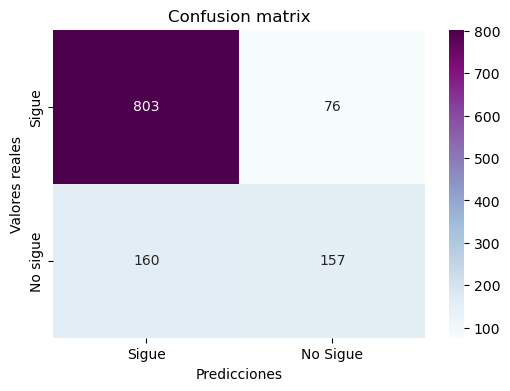

In [27]:
# Calcular la matriz de confusión
cm = confusion_matrix(y_test, y_pred)

# Crear una paleta de colores 'husl'
df_cm = pd.DataFrame(cm, index=['Sigue', 'No sigue'], columns=['Sigue', 'No Sigue'])

# Crear el mapa de calor con la paleta 'husl'
plt.figure(figsize=(6, 4))
sns.heatmap(df_cm, annot=True, fmt='d', cmap='BuPu')
plt.title('Confusion matrix')
plt.xlabel('Predicciones')
plt.ylabel('Valores reales')
plt.show()


El modelo tiene falsos negativos, es decir el modelo predijo que no seguirían algunos de los usuarios que continuan con el plan. 

### PCA


In [28]:
x_train2, x_test2, y_train2, y_test2 = train_test_split(x, y, test_size=0.2, random_state=0)

In [29]:
from sklearn.decomposition import PCA
pca=PCA(n_components=2)

In [30]:
transformacion_num_2 = Pipeline(
    steps=[("scaler", StandardScaler()),("pca",pca)]
)

In [31]:
preprocesamiento2 = ColumnTransformer(transformers=[ ("num", transformacion_num_2, var_num),("cat", transformacion_cat, var_cat),])

In [32]:
pd.DataFrame(preprocesamiento2.fit_transform(x_train2))

,0,1,2,3,4,5,6,7,8,9,...,35,36,37,38,39,40,41,42,43,44
0,0.093713,-0.761444,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
1,-0.809890,-0.509338,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,...,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
2,-0.977642,0.400629,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,...,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
3,2.778423,0.229608,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
4,-1.599355,0.387416,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4776,-1.020399,-0.241745,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
4777,-1.268089,-1.006448,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
4778,2.797004,-0.064691,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,...,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0
4779,-0.132185,1.841839,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0


In [33]:
pipeline2 = Pipeline(steps=[("preprocesamiento", preprocesamiento2),("estimador", LogisticRegression())])
from sklearn import set_config
set_config(display="diagram")
pipeline2
#Vemos como queda el pipeline ahora que agrego el PCA

Pipeline(steps=[('preprocesamiento',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler()),
                                                                  ('pca',
                                                                   PCA(n_components=2))]),
                                                  ['MonthlyCharges',
                                                   'TotalCharges', 'tenure']),
                                                 ('cat', OneHotEncoder(),
                                                  ['gender', 'SeniorCitizen',
                                                   'Partner', 'Dependents',
                                                   'PhoneService',
                                                   'MultipleLines',
                                                   'InternetService',
                                                   'OnlineSecurity',
                                                   'OnlineBackup',
                                                   'DeviceProtection',
                                                   'TechSupport', 'StreamingTV',
                                                   'StreamingMovies',
                                                   'Contract',
                                                   'PaperlessBilling',
                                                   'PaymentMethod'])])),
                ('estimador', LogisticRegression())])

In [34]:
parametros2 = [
   {

        "estimador": (LogisticRegression(),),
          "estimador__C": (0.2,0.6,0.9)
    }, 
    {
        "estimador": (SVC(),),
          "estimador__kernel":('linear', 'rbf'), 
          "estimador__C":(0.01, 0.1,1, 10), 
          "estimador__gamma":(0.01, 0.1,1)          
    }
    ]

In [35]:
#Creamos el GSCV para establecer el mejor modelo e hiperparámetros
GSCV2 = GridSearchCV(pipeline2, parametros2,
                  refit = True, #Devuelve el modelo con los mejores parámetros encontrados 
                   cv = 5, 
                   verbose=3)

In [36]:
GSCV2.fit(x_train2, y_train2.values.ravel())

Fitting 5 folds for each of 27 candidates, totalling 135 fits
[CV 1/5] END estimador=LogisticRegression(), estimador__C=0.2;, score=0.808 total time=   0.0s
[CV 2/5] END estimador=LogisticRegression(), estimador__C=0.2;, score=0.804 total time=   0.0s
[CV 3/5] END estimador=LogisticRegression(), estimador__C=0.2;, score=0.793 total time=   0.0s
[CV 4/5] END estimador=LogisticRegression(), estimador__C=0.2;, score=0.812 total time=   0.0s
[CV 5/5] END estimador=LogisticRegression(), estimador__C=0.2;, score=0.797 total time=   0.0s
[CV 1/5] END estimador=LogisticRegression(), estimador__C=0.6;, score=0.808 total time=   0.0s
[CV 2/5] END estimador=LogisticRegression(), estimador__C=0.6;, score=0.802 total time=   0.0s
[CV 3/5] END estimador=LogisticRegression(), estimador__C=0.6;, score=0.793 total time=   0.0s
[CV 4/5] END estimador=LogisticRegression(), estimador__C=0.6;, score=0.811 total time=   0.0s
[CV 5/5] END estimador=LogisticRegression(), estimador__C=0.6;, score=0.798 total t

[CV 4/5] END estimador=SVC(), estimador__C=0.1, estimador__gamma=1, estimador__kernel=linear;, score=0.808 total time=   0.5s
[CV 5/5] END estimador=SVC(), estimador__C=0.1, estimador__gamma=1, estimador__kernel=linear;, score=0.799 total time=   0.4s
[CV 1/5] END estimador=SVC(), estimador__C=0.1, estimador__gamma=1, estimador__kernel=rbf;, score=0.731 total time=   1.3s
[CV 2/5] END estimador=SVC(), estimador__C=0.1, estimador__gamma=1, estimador__kernel=rbf;, score=0.732 total time=   1.4s
[CV 3/5] END estimador=SVC(), estimador__C=0.1, estimador__gamma=1, estimador__kernel=rbf;, score=0.732 total time=   1.2s
[CV 4/5] END estimador=SVC(), estimador__C=0.1, estimador__gamma=1, estimador__kernel=rbf;, score=0.732 total time=   1.1s
[CV 5/5] END estimador=SVC(), estimador__C=0.1, estimador__gamma=1, estimador__kernel=rbf;, score=0.732 total time=   1.1s
[CV 1/5] END estimador=SVC(), estimador__C=1, estimador__gamma=0.01, estimador__kernel=linear;, score=0.800 total time=   0.4s
[CV 2/

[CV 5/5] END estimador=SVC(), estimador__C=10, estimador__gamma=1, estimador__kernel=rbf;, score=0.749 total time=   1.5s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocesamiento',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('scaler',
                                                                                          StandardScaler()),
                                                                                         ('pca',
                                                                                          PCA(n_components=2))]),
                                                                         ['MonthlyCharges',
                                                                          'TotalCharges',
                                                                          'tenure']),
                                                                        ('cat',
                                                                         OneHotEncoder(),
                                                                         ['gender',
                                                                          'SeniorCitizen',
                                                                          'Partner',
                                                                          'Dependents',
                                                                          'PhoneService',
                                                                          'MultipleLines',
                                                                          'InternetService',
                                                                          'OnlineS...
                                                                          'TechSupport',
                                                                          'StreamingTV',
                                                                          'StreamingMovies',
                                                                          'Contract',
                                                                          'PaperlessBilling',
                                                                          'PaymentMethod'])])),
                                       ('estimador', LogisticRegression())]),
             param_grid=[{'estimador': (LogisticRegression(C=0.2),),
                          'estimador__C': (0.2, 0.6, 0.9)},
                         {'estimador': (SVC(),),
                          'estimador__C': (0.01, 0.1, 1, 10),
                          'estimador__gamma': (0.01, 0.1, 1),
                          'estimador__kernel': ('linear', 'rbf')}],
             verbose=3)

In [37]:
# Toda la información del entrenamiento esta en cv_results_
scores2 = GSCV2.cv_results_
#Veamosla ...
scores = pd.DataFrame.from_dict(scores2)
scores.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_estimador,param_estimador__C,param_estimador__gamma,param_estimador__kernel,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.063158,0.008865,0.004329,0.006110,LogisticRegression(C=0.2),0.2,NaN,NaN,"{'estimador': LogisticRegression(C=0.2), 'esti...",0.807732,0.804393,0.792887,0.811715,0.797071,0.802760,0.006891,1
1,0.060396,0.006555,0.006251,0.007656,LogisticRegression(C=0.2),0.6,NaN,NaN,"{'estimador': LogisticRegression(C=0.2), 'esti...",0.807732,0.802301,0.792887,0.810669,0.798117,0.802341,0.006413,3
2,0.055196,0.012106,0.015199,0.000843,LogisticRegression(C=0.2),0.9,NaN,NaN,"{'estimador': LogisticRegression(C=0.2), 'esti...",0.806688,0.801255,0.794979,0.810669,0.798117,0.802342,0.005683,2
3,0.331593,0.033218,0.063387,0.001590,SVC(),0.01,0.01,linear,"{'estimador': SVC(), 'estimador__C': 0.01, 'es...",0.802508,0.807531,0.790795,0.809623,0.800209,0.802133,0.006598,4
4,0.584574,0.035133,0.339929,0.010493,SVC(),0.01,0.01,rbf,"{'estimador': SVC(), 'estimador__C': 0.01, 'es...",0.731452,0.732218,0.732218,0.732218,0.732218,0.732065,0.000306,24


In [38]:
print("los mejores parámetros son %s con score de %0.2f" % (GSCV2.best_params_, GSCV2.best_score_))

los mejores parámetros son {'estimador': LogisticRegression(C=0.2), 'estimador__C': 0.2} con score de 0.80


In [39]:
pd.DataFrame(preprocesamiento2.transform(x_test2))

,0,1,2,3,4,5,6,7,8,9,...,35,36,37,38,39,40,41,42,43,44
0,-1.809266,0.646332,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0
1,-0.357840,0.441064,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2,2.848217,-0.087932,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,...,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
3,2.064433,0.584649,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,...,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0
4,-0.317387,-0.950038,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,...,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1191,-1.387137,0.981264,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
1192,-0.291523,-0.305310,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,...,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
1193,3.412145,-0.170404,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,...,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0
1194,0.926050,-0.658481,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,...,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0


In [40]:
y_pred3 = GSCV2.predict(x_test2)
print(y_pred3)

['No' 'No' 'No' ... 'No' 'No' 'No']


In [41]:
# Computo el accuracy (comparar ytest vs ypred)
test_acc = accuracy_score(y_test2, y_pred3)
print("El accuracy es " + str(test_acc))

El accuracy es 0.8043478260869565


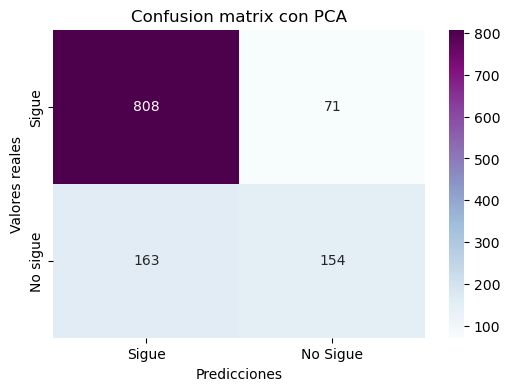

In [42]:
# Confusion Matrix
cm = confusion_matrix(y_test2, y_pred3)
df_cm = pd.DataFrame(cm, index = ['Sigue', 'No sigue'], columns = ["Sigue",'No Sigue'])
plt.figure(figsize = (6,4))
sns.heatmap(df_cm, annot=True,fmt='d', cmap='BuPu')
plt.title('Confusion matrix con PCA')
plt.xlabel('Predicciones')
plt.ylabel('Valores reales')
plt.show()